In [ ]:
from src.main import predictSAVs

query = ['O14508 52 S N', 'O14522 1096 A P']
predictSAVs(
    query=query,
    job_name='test',
    feature_set='ordered_final_v1',
    refresh=True,
)

from src.core import Tandem
import numpy as np 
from prody import LOGGER
LOGGER.start("test.log")
query = ['O14508 52 S N', 'O14522 1096 A P']
labels = [0, np.nan]
t = Tandem(query=query, refresh=True)
t.mapUniprot2PDB()
t.getUniprot2PDBmap()
t.setLabels(labels)
t.setFeatSet(['GNM_Ventropy_full', 'GNM_V1_full'])
withSAVs = True
withLabels = True
t.getFeatMatrix(
        withSAVs=withSAVs, withLabels=withLabels, 
        folder='.', filename='test'
    )


R20000_val: t = 2.11, p = 0.05
R20000_test: t = 6.60, p = 0.00
Validation: t = -1.43, p = 0.17
Test: t = 0.56, p = 0.58
GJB2_val_accuracy improves 2.86% in average
GJB2_test_accuracy improves -1.39% in average


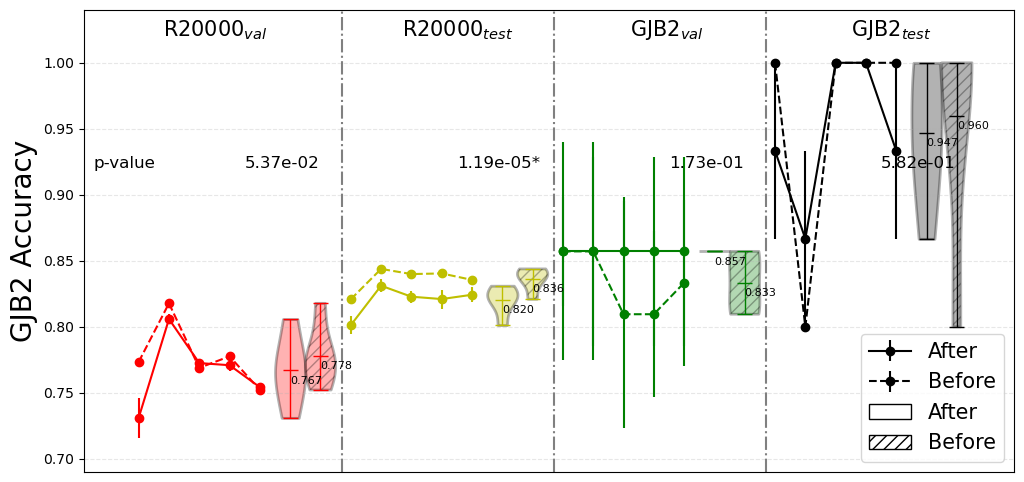

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

transfer_GJB2 = '/mnt/nas_1/YangLab/loci/tandem/logs/TransferLearning_GJB2/GJB2-20250423-1739-seed-17'

df_baseline = pd.read_csv(f'{transfer_GJB2}/baseline.csv')
df_best = pd.read_csv(f'{transfer_GJB2}/best.csv')
index = ' '.join([f'mean_{i} std_{i} sem_{i}' for i in range(5)]).split()
df_baseline.index = index
df_best.index = index

# Extract data
def extract_data(df, prefix, metrics):
    return [[df.loc[f'{prefix}_{i}'][metric] for i in range(5)] for metric in metrics]

metrics = ['R20000_val_accuracy', 'R20000_test_accuracy', 'val_accuracy', 'test_accuracy']

best_data = extract_data(df_best, 'mean', metrics)
best_errors = extract_data(df_best, 'sem', metrics)
base_data = extract_data(df_baseline, 'mean', metrics)
base_errors = extract_data(df_baseline, 'sem', metrics)

################## Calculate t-test ##################
from scipy.stats import ttest_rel
before_transfer = os.path.join(transfer_GJB2, 'before_transfer.csv')
after_transfer = os.path.join(transfer_GJB2, 'after_transfer.csv')
df_before_transfer = pd.read_csv(before_transfer)
df_after_transfer = pd.read_csv(after_transfer)
df_before_transfer = df_before_transfer[metrics]
df_after_transfer = df_after_transfer[metrics]
t_R20000_val = ttest_rel(df_before_transfer['R20000_val_accuracy'], df_after_transfer['R20000_val_accuracy'])
t_R20000_test = ttest_rel(df_before_transfer['R20000_test_accuracy'], df_after_transfer['R20000_test_accuracy'])
t_val = ttest_rel(df_before_transfer['val_accuracy'], df_after_transfer['val_accuracy'])
t_test = ttest_rel(df_before_transfer['test_accuracy'], df_after_transfer['test_accuracy'])

print(f'R20000_val: t = {t_R20000_val.statistic:.2f}, p = {t_R20000_val.pvalue:.2f}')
print(f'R20000_test: t = {t_R20000_test.statistic:.2f}, p = {t_R20000_test.pvalue:.2f}')
print(f'Validation: t = {t_val.statistic:.2f}, p = {t_val.pvalue:.2f}')
print(f'Test: t = {t_test.statistic:.2f}, p = {t_test.pvalue:.2f}')


# Plot data
plt.figure(figsize=(12, 6))
index = np.arange(5)
colors = ['r', 'y', 'g', 'k']
labels = ['R20000_Validation', 'R20000_Test', 'GJB2 Validation', 'GJB2 Test']
positions = [0, 7, 14, 21]

# Plot p-values
# for i, (p, pos) in enumerate(zip([t_val.pvalue, t_test.pvalue, t_GJB2_val.pvalue, t_GJB2_test.pvalue], positions)):
for i, (p, pos) in enumerate(zip([t_R20000_val.pvalue, t_R20000_test.pvalue, t_val.pvalue, t_test.pvalue], positions)):
    if p < 0.001:
        plt.text(pos+3.5, 0.92, f'{p:.2e}*', fontsize=12, color='black')
    elif p < 0.01:
        plt.text(pos+3.5, 0.92, f'{p:.2e}**', fontsize=12, color='black')
    elif p < 0.05:
        plt.text(pos+3.5, 0.92, f'{p:.2e}*', fontsize=12, color='black')
    elif np.isnan(p):
        continue
    else: 
        plt.text(pos+3.5, 0.92, f'{p:.2e}', fontsize=12, color='black')
plt.text(-1.5, 0.92, 'p-value', fontsize=12, color='black')

# Plot data
for i, (best, base, best_err, base_err, color, label, pos) in enumerate(zip(best_data, base_data, best_errors, base_errors, colors, labels, positions)):
    plt.errorbar([x + pos for x in index], best, yerr=best_err, fmt=f'{color}-o')
    plt.errorbar([x + pos for x in index], base, yerr=base_err, fmt=f'{color}--o')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    parts = plt.violinplot([best, base], positions=[pos+5, pos+6], widths=1, showmeans=True, showextrema=True)
    plt.text(pos+5, np.mean(best)-0.01, f'{np.mean(best):.3f}', fontsize=8, color='black')
    plt.text(pos+6, np.mean(base)-0.01, f'{np.mean(base):.3f}', fontsize=8, color='black')

    parts['bodies'][1].set_hatch('///')
    for pc in parts['bodies']:
        pc.set_linewidth(2)
        pc.set_facecolor(color)
        pc.set_edgecolor('black')   
        pc.set_linestyle('solid')
    for partname in ('cbars', 'cmaxes', 'cmins', 'cmeans'):
        parts[partname].set_edgecolor(color)
        parts[partname].set_linewidth(1)

# How much GJB2_val_accuracy and GJB2_test_accuracy improve in average
GJB2_val_imp = np.mean([best_data[2][i] - base_data[2][i] for i in range(5)]) / np.mean(base_data[2])
GJB2_test_imp = np.mean([best_data[3][i] - base_data[3][i] for i in range(5)]) / np.mean(base_data[3])
print(f'GJB2_val_accuracy improves {GJB2_val_imp:.2%} in average')
print(f'GJB2_test_accuracy improves {GJB2_test_imp:.2%} in average')

# Plot GJB2_val_imp and GJB2_test_imp with arrow drawing
# plt.arrow(19+1, np.mean(best_data[2]), 0, 0.01, head_width=0.3, head_length=0.02, fc='r', ec='r')
# plt.arrow(26+1, np.mean(best_data[3]), 0, 0.01, head_width=0.3, head_length=0.02, fc='r', ec='r')
# plt.text(19+1+0.2, np.mean(best_data[2]), f'{GJB2_val_imp:.0%}', fontsize=12, color='r')
# plt.text(26+1+0.2, np.mean(best_data[3]), f'{GJB2_test_imp:.0%}', fontsize=12, color='r')

# Add labels
plt.errorbar([], [], yerr=[], fmt='k-o', label='After')
plt.errorbar([], [], yerr=[], fmt='k--o', label='Before')
plt.bar(0, 0, color='w', edgecolor='black', hatch='', label='After')
plt.bar(0, 0, color='w', edgecolor='black', hatch='///', label='Before')
# Customize plot
# plt.xlabel('General disease model', fontsize=20)
plt.ylabel('GJB2 Accuracy', fontsize=20)
# plt.title('Model performance (transfer learning to GJB2)', fontsize=20)
plt.xticks(labels=['1', '2', '3', '4', '5']*4, ticks=[0, 1, 2, 3, 4, 
                                                    7, 8, 9, 10, 11,
                                                    14, 15, 16, 17, 18,
                                                    21, 22, 23, 24, 25, ])
# Draw the vertical lines at 6.5, 13.5, 20.5
for i in range(3):
    plt.axvline(x=6.7 + 7*i, color='gray', linestyle='-.')

plt.text(0.8, 1.02, r'R20000$_{val}$', fontsize=15, color='black')
plt.text(8.7, 1.02, r'R20000$_{test}$', fontsize=15, color='black')
plt.text(16.2, 1.02, r'GJB2$_{val}$', fontsize=15, color='black')
plt.text(23.5, 1.02, r'GJB2$_{test}$', fontsize=15, color='black')
plt.legend(fontsize=15, loc='lower right')
plt.ylim(0.69, 1.04)
# Remove x-ticks for all subplots except the last row
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
plt.show()

In [ ]:
# R20000
from src.features.PDB import calcPDBfeatures
from src.features.SEQ import calcSEQfeatures
import pandas as pd
from prody import LOGGER
LOGGER.start('R200000PDB.log')
file = 'data/mapped_SAVs_with_chain_length_labels.csv'
df = pd.read_csv(file)
sel_feats = ['BLOSUM',
    'phobic_percent', 'delta_phobic_percent',
    'philic_percent', 'delta_philic_percent',
    'charge', 'deltaCharge',
    'polarity', 'deltaPolarity']
# f = calcPDBfeatures(df, folder='data', refresh=False, sel_feats=sel_feats, withSAV=True) 
f = calcSEQfeatures(
    df['SAV_coords'].tolist(),
    folder='data',
    refresh=False,
    sel_feats=sel_feats,
    withSAV=True,
)
# df

# RYR1
import pandas as pd 
from src.core import Tandem, calcFeatures
from src.features import feats
df = pd.read_csv("data/RYR1/SAVs.csv")
SAV_coords = df['SAV_coords'].tolist()
labels = df['labels'].tolist()
custom_PDB = '7M6L'
fns = list(feats.keys())
fns = ['entropy', 'ranked_MI']
fm = calcFeatures(
        query=SAV_coords,
        labels=labels,
        job_name='RYR1_pfam',
        custom_PDB=custom_PDB,
        refresh=False,
        featSet=fns,
        withSAVs=True,
        withLabels=True,
        folder='data',
)

# GJB2
from src.features.PDB import calcPDBfeatures
import pandas as pd 
from src.core import Tandem, calcFeatures
df = pd.read_csv("data/GJB2/SAVs.csv")
SAV_coords = df['SAV_coords'].tolist()
labels = df['labels'].tolist()
custom_PDB = 'data/GJB2/structures/8qa2_opm_25Apr03.pdb'
fns = 'wtBJCE,deltaBJCE,consurf,ACNR,wtPSIC,deltaPSIC,IDRs,SSbond,SF1,SF2,SF3,chain_length,protein_length,AG1,AG3,AG5,ACR,Rg,Dcom,loop_percent,helix_percent,sheet_percent,dssp,SASA,SASA_in_complex,deltaSASA,Hbond,GNM_Ventropy_reduced,GNM_rmsf_overall_reduced,GNM_Eigval1_reduced,GNM_Eigval2_reduced,GNM_Eigval5_1_reduced,GNM_SEall_reduced,GNM_SE20_reduced,GNM_V1_reduced,GNM_rankV1_reduced,GNM_V2_reduced,GNM_rankV2_reduced,GNM_co_rank_reduced,GNM_displacement_reduced,GNM_MC1_reduced,GNM_MC2_reduced,ANM_effectiveness_reduced,ANM_sensitivity_reduced,ANM_stiffness_reduced,BLOSUM,phobic_percent,delta_phobic_percent,charge,deltaCharge,polarity,deltaPolarity,DELTA_Rg,DELTA_Dcom,DELTA_SASA,DELTA_ACR,DELTA_Hbond,DELTA_DSS,DELTA_charge_pH7,Lside,deltaLside,charge_pH7,GNM_Ventropy_full,GNM_rmsf_overall_full,GNM_Eigval1_full,GNM_Eigval2_full,GNM_Eigval5_1_full,GNM_SEall_full,GNM_SE20_full,GNM_V1_full,GNM_rankV1_full,GNM_V2_full,GNM_rankV2_full,GNM_co_rank_full,GNM_displacement_full,GNM_MC1_full,GNM_MC2_full,entropy,ranked_MI,ANM_effectiveness_chain,ANM_sensitivity_chain,ANM_stiffness_chain'.split(',')
fm = calcFeatures(
        query='P29033',
        labels=labels,
        job_name='GJB2_full',
        custom_PDB=custom_PDB,
        refresh=True,
        featSet=fns,
        withSAVs=True,
        withLabels=True,
        folder='data',
)

t = Tandem(query=SAV_coords, filename='2ZW3_equi')
t.setFeatSet(fns)

t.setCustomPDB(custom_PDB)
t.setLabels(labels)
arr = t.getFeatMatrix(True, True)

# PKD1

import pandas as pd 
from src.core import Tandem, calcFeatures
from src.features import feats
sav = 'data/PKD1/SAVs.csv'
custom_PDB = 'data/PKD1/fold_1xpkd1/fold_1xpkd1_model_0.cif'
df = pd.read_csv(sav)
df = df[df['gene'] == 'PKD1']
SAV_coords = df['SAV_coords'].tolist()
labels = df['labels'].tolist()
fns = list(feats.keys())

fns = ['DELTA_Rg', 'DELTA_Dcom', 'DELTA_SASA', 'DELTA_ACR', 
             'DELTA_Hbond', 'DELTA_DSS', 'DELTA_charge_pH7']
fns = ['GNM_Ventropy_full', 'GNM_rmsf_overall_full', 'GNM_Eigval1_full', 'GNM_Eigval2_full', 'GNM_Eigval5_1_full', 'GNM_SEall_full', 'GNM_SE20_full', 'GNM_V1_full', 'GNM_rankV1_full', 'GNM_V2_full', 'GNM_rankV2_full', 'GNM_co_rank_full', 'GNM_displacement_full', 'GNM_MC1_full', 'GNM_MC2_full', 'ANM_effectiveness_chain', 'ANM_sensitivity_chain', 'ANM_stiffness_chain', 'wtBJCE', 'deltaBJCE']
fm = calcFeatures(
    query=SAV_coords,
    labels=labels,
    job_name='PKD1_DYN',
    custom_PDB=custom_PDB,
    refresh=False,
    featSet=fns,
    withSAVs=True,
    withLabels=True,
    folder='data',
)

In [47]:
import pandas as pd 

df_SAVs = '/mnt/nas_1/YangLab/loci/tandem/data/GJB2/SAVs.csv'
df_SAVs = pd.read_csv(df_SAVs)
df = '/mnt/nas_1/YangLab/loci/tandem/data/GJB2/rhapsody-predictions.csv'
df = pd.read_csv(df)
for i, row in df.iterrows():
    SAVs = row['SAV_coords']
    sel = df_SAVs[df_SAVs['SAV_coords'] == SAVs]
    label = sel['labels'].values[0]
    c = row['class']
    if "neutral" in c:
        pred = 0
    elif "delet" in c:
        pred = 1
    df.at[i, 'pred.'] = pred
    df.at[i, 'labels'] = sel['labels'].values[0]
    if pred == label:
        df.at[i, 'correct'] = 1
    else:
        df.at[i, 'correct'] = 0
# df.to_csv('data/RYR1/rhapsody-predictions.csv', index=False)

In [39]:
from src.main import tandem_dimple

td = tandem_dimple(
    query=['O14508 52 S N', 'O14522 1096 A P'],
    job_name='test2',
    models='logs/final/different_number_of_layers/20250423-1234-tandem/n_hidden-5',
    r20000='data/R20000/final_features.csv',
    custom_PDB=None,
    refresh=True,
    folder='data',
    )

labels
1.0    45
0.0    45
Name: count, dtype: int64

In [ ]:
sav = '/mnt/nas_1/YangLab/loci/tandem/data/PKD1/SAVs.csv'
import pandas as pd 
from src.core import Tandem, calcFeatures
df = pd.read_csv(sav)
df = df[df['gene'] == 'PKD1']
# Remove duplicates
df = df.drop_duplicates(subset=['SAV_coords'])
fns = 'wtBJCE,deltaBJCE,consurf,ACNR,wtPSIC,deltaPSIC,IDRs,SSbond,SF1,SF2,SF3,chain_length,protein_length,AG1,AG3,AG5,ACR,Rg,Dcom,loop_percent,helix_percent,sheet_percent,dssp,SASA,SASA_in_complex,deltaSASA,Hbond,GNM_Ventropy_reduced,GNM_rmsf_overall_reduced,GNM_Eigval1_reduced,GNM_Eigval2_reduced,GNM_Eigval5_1_reduced,GNM_SEall_reduced,GNM_SE20_reduced,GNM_V1_reduced,GNM_rankV1_reduced,GNM_V2_reduced,GNM_rankV2_reduced,GNM_co_rank_reduced,GNM_displacement_reduced,GNM_MC1_reduced,GNM_MC2_reduced,ANM_effectiveness_reduced,ANM_sensitivity_reduced,ANM_stiffness_reduced,BLOSUM,phobic_percent,delta_phobic_percent,charge,deltaCharge,polarity,deltaPolarity,DELTA_Rg,DELTA_Dcom,DELTA_SASA,DELTA_ACR,DELTA_Hbond,DELTA_DSS,DELTA_charge_pH7,Lside,deltaLside,charge_pH7,GNM_Ventropy_full,GNM_rmsf_overall_full,GNM_Eigval1_full,GNM_Eigval2_full,GNM_Eigval5_1_full,GNM_SEall_full,GNM_SE20_full,GNM_V1_full,GNM_rankV1_full,GNM_V2_full,GNM_rankV2_full,GNM_co_rank_full,GNM_displacement_full,GNM_MC1_full,GNM_MC2_full,entropy,ranked_MI,ANM_effectiveness_chain,ANM_sensitivity_chain,ANM_stiffness_chain'.split(',')
SAV_coords = df['SAV_coords'].tolist()
labels = df['labels'].tolist()
custom_PDB = 'data/PKD1/fold_1xpkd1/fold_1xpkd1_model_0.cif'

# Set up the Tandem object
t = Tandem(query=SAV_coords)

# Set custom PDB structure
if custom_PDB:
    t.setCustomPDB(custom_PDB)

# Set labels
if labels is not None:
    t.setLabels(labels)

# Save the Uniprot2PDB map
t.getUniprot2PDBmap(folder='.', filename='PKD1')

from src.fixer import fixPDB
pdbID = 'AF-P29033-F1-model_v4'
format = 'af2'
pdbPath = fixPDB(pdbID, format, folder='.', refresh=True)

In [ ]:
import numpy as np
import pandas as pd

path = '/mnt/nas_1/YangLab/loci/improve'
rhdfeat_path = f'{path}/data/rhd_feat.npy'

# Load data
rhdfeat = np.load(rhdfeat_path)
df = pd.DataFrame(rhdfeat)
feat_names = list(rhdfeat.dtype.names)[4:]

rhd_GJB2_path = f'{path}/data/GJB2/rhdfeat_Jul4.tsv'
df_GJB2 = pd.read_csv(rhd_GJB2_path, sep='\t')

df_features = '/mnt/nas_1/YangLab/loci/tandem/data/GJB2/features_25Apr01.csv'
df_features = pd.read_csv(df_features)
sel_features = ['entropy','ranked_MI',]
for i, row in df_GJB2.iterrows():
    SAV = row['SAV_coords']
    sel = df_features[df_features['SAV_coords'] == SAV]
    for f in sel_features:
        df_GJB2.at[i, f] = sel[f].values[0]
        
df_GJB2 = df_GJB2[~df_GJB2['labels'].isnull()]
test_fm = df_GJB2[feat_names].values

from src.predict.inference import ModelInference
mi = ModelInference(models='models/rhapsody', r20000='rhdfeat.csv', feat_names=feat_names)
a, amean, asem = mi.calcAccuracy(test_fm, df_GJB2['labels'].values) 


rhd_RYR1_path = f'{path}/data/RYR1/rhdfeat_Jun24.tsv'
df_RYR1 = pd.read_csv(rhd_RYR1_path, sep='\t')
sel_features = ['entropy','ranked_MI']
df_features = '/mnt/nas_1/YangLab/loci/tandem/data/RYR1/feat_rename_and_recal_otherfeatures_features_24May20.csv'
df_features = pd.read_csv(df_features)
for i, row in df_RYR1.iterrows():
    SAV = row['SAV_coords']
    sel = df_features[df_features['SAV_coords'] == SAV]
    for f in sel_features:
        df_RYR1.at[i, f] = sel[f].values[0]
df_RYR1 = df_RYR1[~df_RYR1['labels'].isnull()]
test_fm = df_RYR1[feat_names].values

from src.predict.inference import ModelInference
mi = ModelInference(models='/mnt/nas_1/YangLab/loci/improve/train/logs/thesis-Optimization/rhd-20240706-2151-seed-150/n_hidden_6', 
                    r20000='rhdfeat.csv', feat_names=feat_names)
a, amean, asem = mi.calcAccuracy(test_fm, df_RYR1['labels'].values)